# Sequential Data and Recurrent Neural Networks (RNN)
- Neural networks for sequences of data, e.g., speech, time series data, essentially anything that generates itself in a sequence. All time series data is sequential, but not all sequential data is time series, e.g., DNA sequences.    
- Order of the data is important, i.e., $t$ is dependent on $t_{-1}$. Normally our models demand (assume) the data is independently and identically distributed, so this is a departure which requires different techniques and models.  
- See the [Keras RNN Guide](https://keras.io/guides/working_with_rnns/) for more info.

<img src='files/diagrams/sequences.png' style='width: 600 px'>

### Simple Time Series Example

> Data is the S&P500 stock index, a very time series data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

stocks = pd.read_csv('data/stocks.csv')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16467 entries, 0 to 16466
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16467 non-null  object 
 1   Open       16467 non-null  float64
 2   High       16467 non-null  float64
 3   Low        16467 non-null  float64
 4   Close      16467 non-null  float64
 5   Volume     16467 non-null  int64  
 6   Adj Close  16467 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 900.7+ KB


In [2]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.set_index('Date')
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-12,2107.429932,2107.429932,2091.330078,2094.110107,2719400000,2094.110107
2015-06-11,2106.239990,2115.020020,2106.239990,2108.860107,3128600000,2108.860107
2015-06-10,2081.120117,2108.500000,2081.120117,2105.199951,3414320000,2105.199951
2015-06-09,2079.070068,2085.620117,2072.139893,2080.149902,3034580000,2080.149902
2015-06-08,2092.340088,2093.010010,2079.110107,2079.280029,2917150000,2079.280029


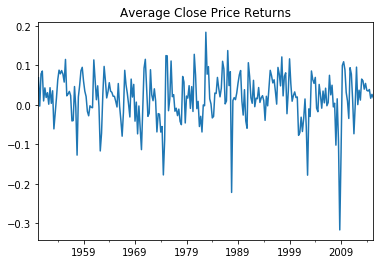

In [3]:
closePrice = stocks['Close'].resample('Q').mean()
closePrice = np.log(closePrice)
closePrice = closePrice.diff()
closePrice = closePrice[closePrice.notna()]

closePrice.plot()
plt.title('Average Close Price Returns')
plt.xlabel('')
plt.ylabel('')
plt.show()

> Might be valuable if we could predict future values?

### Differences from ANNs
> Looking at blocks of memory versus neurons.  

> Blocks have gates with similar concepts to how memories work, e.g., input, forget, and output gates, which are similar to a state space concept (e.g., Markov model).

<img src='files/diagrams/ann-vs-recurrent.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)

#### Activations Computed with a Weight Matrix that takes $t0$ `and` $t_{-1}$


<img src='files/diagrams/recurrent-form.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)




In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppress silly warnings
tf.autograph.set_verbosity(
    5, alsologtostdout=False
)

np.random.seed(10)

# Need to scale the data
cP = np.array(closePrice)
cP = cP.reshape(-1,1)
cP.shape

(261, 1)

#### Split into training and test

In [5]:
train_size = int(len(cP) * 0.80)
test_size = len(cP) - train_size

train, test = cP[0:train_size,:], cP[train_size:len(cP),:]
print(len(train), len(test))

208 53


### Function to create the data set
Pieces borrowed from: [Machine Learning Mastery Time Series Blog](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [6]:
def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Build Models
> Notice we are using `Long-term Short-term` (LSTM) layers for recurrent networks.

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [9]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

### Evaluate Predictions

In [10]:
import math 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict.shape, testPredict.shape

((206, 1), (51, 1))

In [11]:
trainY = trainY.reshape(-1,1)
trainY.shape

(206, 1)

In [12]:
testY = testY.reshape(-1,1)
testY.shape

(51, 1)

In [13]:
# Calculate root mean squared error
import math

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.07 RMSE


In [14]:
results = np.concatenate((trainY, testY), axis=0)
results.shape

(257, 1)

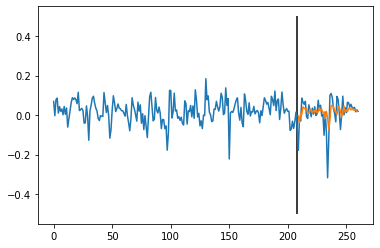

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(cP)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(cP)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(cP)-1, :] = testPredict

# plot baseline and predictions
plt.plot(cP)
plt.plot(testPredictPlot)
plt.vlines(train_size,-0.5,0.5)
plt.show()

> There are many methods for time series, see [Hyndman's Text](https://otexts.com/fpp2/) for techniques and additional non-neural network models.

### IMDB (yes, again `:)` ) for Sentiment Analysis
> Another version of RNN is a many-many model:

<img src='files/diagrams/manymany.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [18]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


> Returns array with indices for the vocabulary

In [19]:
x_train.shape

(25000, 200)

In [20]:
x_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

Below adds an embedding layer that is 32 dimensions (features) of a real-valued vector.

[Explanation on Embeddings](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

[TensorFlow Guide to Work Embeddings](https://www.tensorflow.org/text/guide/word_embeddings)

In [21]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
input_array = np.array([4, 1, 3, 3, 3])

model = Sequential()
model.add(Embedding(5, 2, input_length=5))

input_array = np.random.randint(5, size=(1, 5))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

output_array

array([[[-1.7713755e-05, -2.8161347e-02],
        [ 2.3499917e-02, -7.0070401e-03],
        [ 2.7876981e-03, -1.3986148e-02],
        [-1.7713755e-05, -2.8161347e-02],
        [-4.2062949e-02, -2.5035037e-02]]], dtype=float32)

In [22]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Elapsed time: 0:10:16.318964


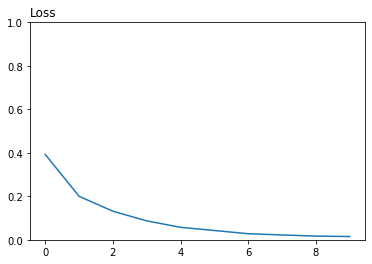

In [23]:
import datetime

st = datetime.datetime.now()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val),
    verbose=0
)

en = datetime.datetime.now()

el = en - st
print(f'Elapsed time: {el}')

plt.plot(history.history['loss'])
plt.title('Loss', loc='left')
plt.ylim((0,1))
plt.show()